<a href="https://colab.research.google.com/github/adytiapp/hotel_booking_cancellation/blob/main/Hotel_Cancellation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to analyze the hotel booking dataset provided by kaggle. The data is originally from the article Hotel Booking Demand Datasets, written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

# Abstract

This data article describes two datasets with hotel demand data. One of the hotels (H1) is a resort hotel and the other is a city hotel (H2). Both datasets share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. Each observation represents a hotel booking. Both datasets comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled. Since this is hotel real data, all data elements pertaining hotel or costumer identification were deleted. Due to the scarcity of real business data for scientific and educational purposes, these datasets can have an important role for research and education in revenue management, machine learning, or data mining, as well as in other fields.

# Data Preparation

Preparation

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 42

Load Data

In [ ]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1PtgmKAgd_PV8OxD545NAlMbH8UPPS-oa/edit#gid=623757277'
sheet_url_trf = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df_ori = pd.read_csv (sheet_url_trf)
df_ori.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,average_daily_rate,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_date_month,total_day_stays,total_guests,clusters
0,1,0,342,2015,27,0,0,2,0,0,...,0.0,0,0,Check-Out,7/1/2015,2015-07-01 00:00:00,7,0,2,0
1,1,0,737,2015,27,0,0,2,0,0,...,0.0,0,0,Check-Out,7/1/2015,2015-07-01 00:00:00,7,0,2,0
2,1,0,7,2015,27,0,1,1,0,0,...,75.0,0,0,Check-Out,7/2/2015,2015-07-01 00:00:00,7,1,1,2
3,1,0,13,2015,27,0,1,1,0,0,...,75.0,0,0,Check-Out,7/2/2015,2015-07-01 00:00:00,7,1,1,2
4,1,0,14,2015,27,0,2,2,0,0,...,98.0,0,1,Check-Out,7/3/2015,2015-07-01 00:00:00,7,2,2,2


Making a copy so the original dataset isn't affected

In [ ]:
df = df_ori.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118898 entries, 0 to 118897
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  int64  
 1   is_canceled                     118898 non-null  int64  
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_week_number        118898 non-null  int64  
 5   stays_in_weekend_nights         118898 non-null  int64  
 6   stays_in_week_nights            118898 non-null  int64  
 7   adults                          118898 non-null  int64  
 8   children                        118898 non-null  int64  
 9   babies                          118898 non-null  int64  
 10  meal                            118898 non-null  object 
 11  country                         118898 non-null  object 
 12  market_segment  

# Booking Cancellation Predictions

**Model Preparation**

We do not want to leak any information about our target (cancellation) into our model. As a result, we must remove is_canceled, reservation_status, and country from our X variable.

Finally, as models cannot take in datetime objects as features, the reservation_status_date and arrival_date_full features were also excluded from the clustering model. It is worth noting that information about the arrival date is still included in the model thanks to the arrival_date_year, arrival_date_month, and arrival_date_day_of_month features. In addition, information about the reservation status date was used to generate the status_minus_arrival_date feature.

In [ ]:
df = pd.get_dummies(df, columns=['meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'clusters'])

In [ ]:
X = df.drop(columns=['is_canceled','reservation_status', 'country', 
                     'reservation_status_date', 'arrival_date'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y, test_size=0.15)

**Modelling**

Our goal is to build a model able to predict whether or not a booking will be canceled with the highest level of accuracy. In order to do so, our baseline model was compared to a logistic regression, a decision tree, a bagging classifier, and random forest.

**Baseline Model**

In [ ]:
# Checking baseline model score 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print(f'Baseline Training Score: {dummy.score(X_train, y_train)}')
print(f'Baseline Testing Score: {dummy.score(X_test, y_test)}')

Baseline Training Score: 0.6286474773161296
Baseline Testing Score: 0.6286515278945893


**Logistic Regression**

In [ ]:
# Construct Grid Parameters
lg_params = {
    'penalty': ['l1'], 
    'C': [3.5],
    'max_iter': [300]
}

# Perform Grid Search
lg_gs = GridSearchCV(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
                 lg_params,
                 cv = 5,
                 scoring = 'accuracy')
lg = lg_gs.fit(X_train, y_train)

print(f'Best Training Accuracy: {lg.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {lg.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(lg.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.8119885615902952
Best Testing Accuracy: 0.8155312587608635
Cross-val-score: 0.8123097331889658


Interpretation: This model is not overfit or underfit (the training and testing scores are close together). The model is outperforming the baseline with a testing accuracy of 81.2%. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data.

Since the logistic regression model does not provide predictive power as high as we would like, we will attempt a more complex Decision Tree model next.

**Decision Tree**

In [ ]:
# Construct Grid Parameters
dt_params = {
    'max_depth':[None],
    'max_features' : [0.7],
    'min_samples_split': [25], 
    'min_samples_leaf': [1]
}

# Perform Grid Search
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                 dt_params,
                 cv = 5,
                 scoring = 'accuracy')
dt = dt_gs.fit(X_train, y_train)

print(f'Best Training Accuracy: {dt.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {dt.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(dt.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.8995675964497393
Best Testing Accuracy: 0.8333052985702271
Cross-val-score: 0.8320913746999767


Interpretation: This model is slightly overfit with a training score of 95.6% higher than our 93.6% accuracy testing score. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data. Although our model is slightly overfit, the high testing score indicates that it still provides high predictive power.

Since our Decision Tree model is overfit, we will try a Bagging Classifier model next in order to increase performance and reduce variance.

**Bagging Classifier**

In [ ]:
# Construct Grid Parameters
bc_params = {
    'n_estimators': [45], 
    'max_features': [0.8]
}

# Perform Grid Search
bc_gs = GridSearchCV(BaggingClassifier(random_state=RANDOM_STATE),
                 bc_params,
                 cv = 5,
                 scoring = 'accuracy')
bc = bc_gs.fit(X_train, y_train)

print(f'Best Training Accuracy: {bc.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {bc.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(bc.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.9914409823575393
Best Testing Accuracy: 0.8689655172413793
Cross-val-score: 0.8672391531763738


Interpretation: This model is overfit with a training score of 99.9% higher than our 96.5% accuracy testing score. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data. Although our model is overfit, the high testing score indicates that it still provides high predictive power.

Since our Bagging Classifier model is overfit, we will try a Random Forest next to introduce more randomness and hopefully decrease the variance.

In [ ]:
# Construct Grid Parameters
rf_params = {
    'n_estimators': [150],  
    'max_features': [50],
    'max_depth': [13]
}

# Perform Grid Search
rf_gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                 rf_params,
                 cv = 5,
                 scoring = 'accuracy')
rf = rf_gs.fit(X_train, y_train)

print(f'Best Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {rf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(rf.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.8480848579598864
Best Testing Accuracy: 0.8404821979254276
Cross-val-score: 0.8368938166281739


In [ ]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.108 seconds


In [ ]:
forest.feature_names = list(X_train.columns.values)

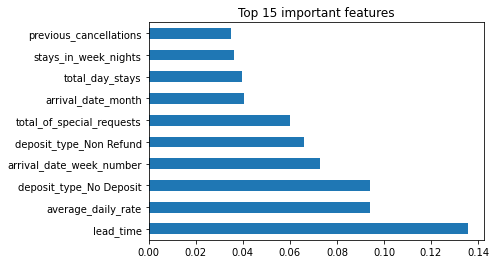

In [ ]:
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

In [ ]:
feat_importances.nlargest(10)

lead_time                    0.135545
average_daily_rate           0.094105
deposit_type_No Deposit      0.093970
arrival_date_week_number     0.072934
deposit_type_Non Refund      0.066119
total_of_special_requests    0.059988
arrival_date_month           0.040477
total_day_stays              0.039683
stays_in_week_nights         0.036301
previous_cancellations       0.034808
dtype: float64

Interpretation: Our model's training score of 92.1% is close to our 91.2% accuracy testing score meaning that we have successfully reduced the variance. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data. The high testing score indicates that this model provides high predictive power.

While our Random Forest model performs with a much higher accuracy than our baseline model, we will try a more complex Neural Network next in order to try and increase our predictive power even more.

In [ ]:
predictive_model_scores = pd.DataFrame(data=[('Baseline',0.6286, 0.6286), ('Logistic Regression',0.8119, 0.8155), 
                                             ('Decision Tree',0.8995, 0.8333), 
                                             ('Random Forest',0.8480, 0.8404)],
                                       columns=['model', 'training_accuracy', 'testing_accuracy'])
predictive_model_scores

,model,training_accuracy,testing_accuracy
0,Baseline,0.6286,0.6286
1,Logistic Regression,0.8119,0.8155
2,Decision Tree,0.8995,0.8333
3,Random Forest,0.8480,0.8404


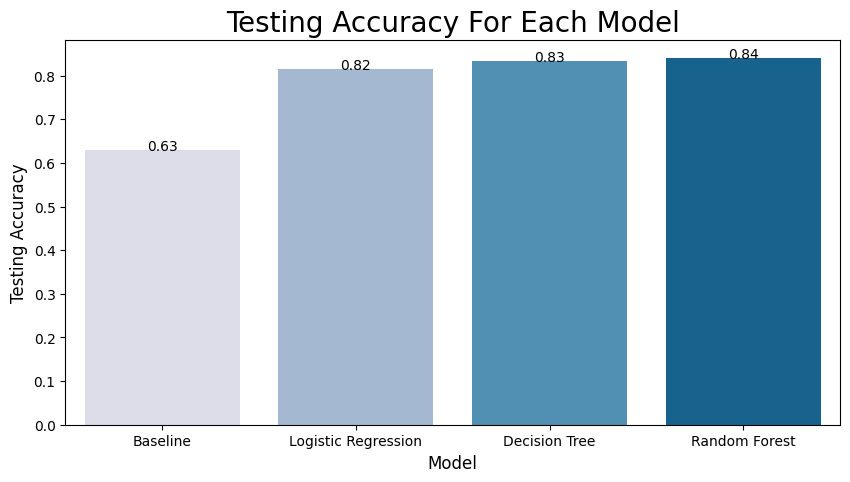

In [ ]:
# Visualizing testing accuracy of each model: 
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='model', y='testing_accuracy', data=predictive_model_scores, palette='PuBu')
plt.title('Testing Accuracy For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('Testing Accuracy', fontsize = 12)
for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_accuracy, s=round(row.testing_accuracy,2), color='black', horizontalalignment='center');

In [ ]:
y_pred = rf.predict(X_test)

y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[10485   727]
 [ 2118  4505]]


In [ ]:
cm_df = pd.DataFrame(cf_matrix, index=['Actually Not Canceled', 'Actually Canceled'],
                 columns=['Predicted Not Canceled', 'Predicted Canceled'])

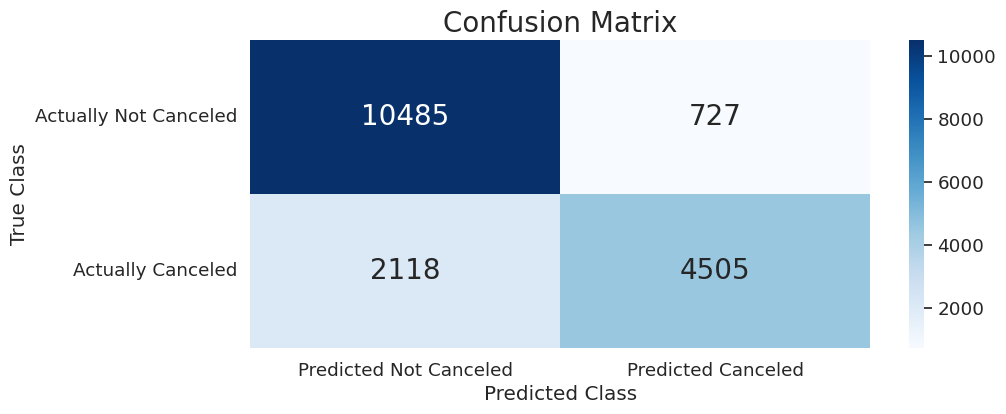

In [ ]:
# visualizing the confusion matrix
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df.columns, yticklabels=cm_df.index, annot_kws={"size": 20})
plt.title("Confusion Matrix", size=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class');

In [ ]:
# True Positives:
TP = 4505
# True Negatives:
TN = 10485
# False Posititives: 
FP = 727
# False Negatives: 
FN = 2118
total = 4505+2118+10485+727

print(f'Correctly classified: {np.round((TP+TN)/total*100)}%')
print(f'Canceled bookings correctly classified: {np.round(TP/(TP+FN)*100)}%')
print(f'Not canceled bookings correctly classified: {np.round(TN/(TN+FP)*100)}%')
print(f'Bookings predicted canceled that are actually canceled: {np.round(TP/(TP+FP)*100)}%')
print(f'Bookings predicted not canceled that are actually not canceled: {np.round(TN/(TN+FN)*100)}%')

Correctly classified: 84.0%
Canceled bookings correctly classified: 68.0%
Not canceled bookings correctly classified: 94.0%
Bookings predicted canceled that are actually canceled: 86.0%
Bookings predicted not canceled that are actually not canceled: 83.0%


In [ ]:
# Creating a dataframe of features and their associated random forest coefficients: 
coefficients = pd.DataFrame(rf.best_estimator_.coef_[0], X_train.columns)
coefficients.rename(columns = {0: 'coef'}, inplace=True)

AttributeError: ignored